https://lilianweng.github.io/lil-log/2019/03/14/are-deep-neural-networks-dramatically-overfitted.html#experiments

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai import datasets

from utils import *

In [3]:
path = datasets.untar_data(datasets.URLs.MNIST)


path.ls()

[PosixPath('/home/quantran/.fastai/data/mnist_png/testing'),
 PosixPath('/home/quantran/.fastai/data/mnist_png/training'),
 PosixPath('/home/quantran/.fastai/data/mnist_png/models')]

In [4]:
path

PosixPath('/home/quantran/.fastai/data/mnist_png')

# Occam's Razor

"Simpler solutions are more likely to be correct than complex ones"

__Minimum Description Length principle__: view LEARNING as DATA COMPRESSION 

$\mathcal{H}^\text{best} = \arg\min_\mathcal{H} [L(\mathcal{H}) + L(\mathcal{D}\vert\mathcal{H})]$

$L(\mathcal{H})$ is the length of the description of model H in bits.

$L(\mathcal{D}\vert\mathcal{H})$ is the length of the description of the data D in bits when encoded with H.

Best model = smallest model containing the data and the model itself

# Preparing databunch and model

In [5]:
# _m = tensor([0.15]*3)
# _s = tensor([0.15]*3)
# norm_mnist = partial(normalize_chan, mean=_m, std=_s)
# norm_mnist._order = 999

In [6]:
# # Build dataset

# def compose2(x, funcs, *args, order_key='_order', **kwargs):
#     key = lambda o: getattr(o, order_key, 0)
#     for f in sorted(listify(funcs), key=key): x = f(x, **kwargs)
#     return x

# class ListContainer():
#     def __init__(self, items): self.items = listify(items)
#     def __getitem__(self, idx):
#         try: return self.items[idx]
#         except TypeError:
#             if isinstance(idx[0],bool):
#                 assert len(idx)==len(self) # bool mask
#                 return [o for m,o in zip(idx,self.items) if m]
#             return [self.items[i] for i in idx]
#     def __len__(self): return len(self.items)
#     def __iter__(self): return iter(self.items)
#     def __setitem__(self, i, o): self.items[i] = o
#     def __delitem__(self, i): del(self.items[i])
#     def __repr__(self):
#         res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
#         if len(self)>10: res = res[:-1]+ '...]'
#         return res

# class MNISTDataset(ListContainer):
#     def __init__(self, items, tfms=[], labelers=[]):
#         '''
#         items: list of PosixPath
#         '''
#         super().__init__(items)
#         self.tfms, self.labeler = tfms, labelers

#     def _get(self,fn):
#         return compose2(PIL.Image.open(fn),self.tfms)
#     def __getitem__(self, idx):
#         items = super().__getitem__(idx)
#         res = [self._get(o) for o in items] if isinstance(items,Iterable) else self._get(items)
        
#         return res,res

# def create_databunch(train_ds, valid_ds, bs, **kwargs):
#     return DataBunch(
#             DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
#             DataLoader(valid_ds, batch_size=bs*2, **kwargs)
#     )

In [48]:
# get_1_channel = lambda x: x[0,:,:]
# get_1_channel._order = 9999

# def get_databunch(tfms=None,bs=64,size=128):
#     il = (ImageList.from_folder(path)
#      .split_by_folder(train='training',valid='testing'))
    
#     if tfms is None: tfms = [make_rgb, np_to_float,norm_mnist, get_1_channel]
#     val_tfms = [make_rgb, np_to_float,norm_mnist,get_1_channel]
    
#     train_ds = MNISTDataset(il.train.items,tfms)
#     val_ds = MNISTDataset(il.valid.items,val_tfms)
#     return train_ds,val_ds
# #     return create_databunch(train_ds,val_ds,bs)

In [5]:
def get_db(bs=64):
    db = (ImageList.from_folder(path)
     .split_by_folder(train='training',valid='testing')
      .label_from_folder()
      .databunch(bs=bs)
      .normalize(mnist_stats)
     )
    return db

In [6]:
db =  get_db()
x,y = next(iter(db.train_dl))

In [7]:
x.shape

torch.Size([64, 3, 28, 28])

In [8]:
def flatten(x): return x.view(x.shape[0],-1)
def linear_relu(i,o,relu=True):
    return nn.Sequential(nn.Linear(i,o),nn.ReLU(True)) if relu else nn.Sequential(nn.Linear(i,o))
class SimpleModel(nn.Module):
    def __init__(self,layers):
        super().__init__()
        l = len(layers)
        self.lin_layers = [linear_relu(layers[i],layers[i+1]) for i in range(l-2)]
        self.lin_layers += [linear_relu(*layers[-2:],relu=False)]
        print()
        self.lin_layers = nn.Sequential(*self.lin_layers)

    def forward(self, x):
        x = flatten(x[:,0,:,:])
        x = self.lin_layers(x)
        return x

In [9]:
def init_cnn(m):
    if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d,nn.Linear)): nn.init.kaiming_normal_(m.weight)
    for l in m.children(): init_cnn(l)

In [10]:
def create_model(layers):    
    # layers = [28*28,256,256,256,10]
    model = SimpleModel(layers).cuda()
    init_cnn(model)

    learn = Learner(db,SimpleModel(layers).cuda(),metrics=[accuracy])
    learn.loss_func = CrossEntropyFlat()
    return learn

In [12]:
def reset_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
#     tf.set_random_seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
# reset_seed()

In [11]:
layers = [28*28,256,256,256,10]
learn = create_model(layers)

In [12]:
learn.model

SimpleModel(
  (lin_layers): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=256, bias=True)
      (1): ReLU(inplace)
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): ReLU(inplace)
    )
    (2): Sequential(
      (0): Linear(in_features=128, out_features=10, bias=True)
    )
  )
)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


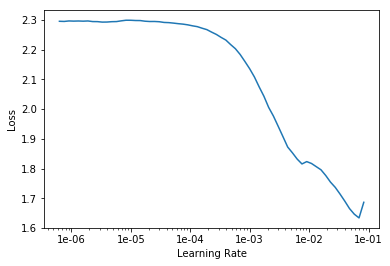

In [17]:
learn.lr_find()
learn.recorder.plot()

In [17]:
# learn.fit_one_cycle(20, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.164555,0.147472,0.954200,00:06
1,0.159317,0.186540,0.949200,00:05
2,0.221095,0.180407,0.951400,00:05
3,0.225905,0.219448,0.945600,00:05
4,0.241616,0.225360,0.943600,00:06
5,0.233782,0.256325,0.945000,00:05
6,0.198219,0.182154,0.955900,00:06
7,0.180066,0.245560,0.944000,00:05
8,0.164116,0.155210,0.964500,00:06
9,0.159593,0.171016,0.962200,00:05


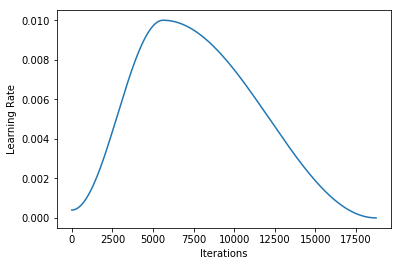

In [22]:
learn.recorder.plot_lr()

# What exactly are inp and outp for forward hook and grad_in and grad_out for backward hook?

In [60]:
from fastai.callbacks.hooks import *

In [61]:
def _hook_out(m,i,o): return o if isinstance(o,Tensor) else o if is_listy(o) else list(o)
def _hook_in(m,i,o): return i if isinstance(i,Tensor) else i if is_listy(i) else list(i)

In [62]:
def reset_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
#     tf.set_random_seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
reset_seed()

In [63]:
def hooked_both(target_layer):
    with Hook(target_layer,_hook_out,is_forward=True) as hook_a_out: 
        with Hook(target_layer,_hook_in,is_forward=True) as hook_a_in:
            with Hook(target_layer,_hook_out,is_forward=False) as hook_g_out:
                with Hook(target_layer,_hook_in,is_forward=False) as hook_g_in:
                    pred = m(xb)
                    err = learn.loss_func(pred,yb)
                    err.backward()
    return hook_a_out,hook_a_in,hook_g_out,hook_g_in

In [66]:
db = get_db()

## For sequential (linear + RELU)

In [87]:
reset_seed()

In [88]:
learn = create_model([28*28,256,128,10])

xb,yb = next(iter(db.valid_dl))

m = learn.model.eval()

layers = list(m.children())

In [89]:
layers[0][1]

Sequential(
  (0): Linear(in_features=256, out_features=128, bias=True)
  (1): ReLU(inplace)
)

In [90]:
hook_a_out,hook_a_in,hook_g_out,hook_g_in = hooked_both(layers[0][1])

len(hook_a_in.stored),hook_a_in.stored[0].shape, hook_a_out.stored.shape
# input of sequential is 256 (from linear), output is 128 (from RELU, NOT FROM LINEAR)

(1, torch.Size([64, 256]), torch.Size([64, 128]))

In [72]:
# grad input: gradient of loss w.r.t input of the last operation of the sequential = dloss/d_RELU_input
# THIS MEANS THIS GRAD ALREADY FACTORS IN THE RELU PART (since we are working backward)
len(hook_g_in.stored),hook_g_in.stored[0].shape, 

(1, torch.Size([64, 128]))

In [73]:
# grad output: gradient of loss w.r.t output of sequential (in this case RELU, a.k.a dloss/d_RELU_output)
len(hook_g_out.stored),hook_g_out.stored[0].shape

(1, torch.Size([64, 128]))

## For linear

In [74]:
reset_seed()

In [75]:
learn = create_model([28*28,256,128,10])

xb,yb = next(iter(db.valid_dl))

m = learn.model.eval()

layers = list(m.children())

In [76]:
layers[0][1][0]

Linear(in_features=256, out_features=128, bias=True)

In [77]:
hook_a_out1,hook_a_in1,hook_g_out1,hook_g_in1 = hooked_both(layers[0][1][0])

len(hook_a_in1.stored),hook_a_in1.stored[0].shape, hook_a_out1.stored.shape

# input of said layer (linear) is 256, output is 128 (BOTH ARE FROM LINEAR)

(1, torch.Size([64, 256]), torch.Size([64, 128]))

In [79]:
# check if input from this Linear and above Sequential are the same
(hook_a_in1.stored[0] != hook_a_in.stored[0]).sum().

tensor(0, device='cuda:0')

In [80]:
# grad input: gradient of loss wrt linear input and loss wrt weight (with bias)
# including: dloss/d_bias, dloss/d_linear_input, dloss/d_weight
len(hook_g_in1.stored),hook_g_in1.stored[0].shape,hook_g_in1.stored[1].shape,hook_g_in1.stored[2].shape

(3, torch.Size([128]), torch.Size([64, 256]), torch.Size([256, 128]))

In [81]:
# grad output is the gradient of loss w.r.t to output of linear (of shape 128, a.k.a dloss/d_linear_output)
len(hook_g_out1.stored),hook_g_out1.stored[0].shape

(1, torch.Size([64, 128]))

In [83]:
# dloss/d_linear_output == dloss/d_RELU_input
(hook_g_out1.stored[0] != hook_g_in.stored[0]).sum()

tensor(0, device='cuda:0')

## For RELU

In [91]:
reset_seed()

learn = create_model([28*28,256,128,10])

xb,yb = next(iter(db.valid_dl))

m = learn.model.eval()

layers = list(m.children())

In [92]:
layers[0][1][1]

ReLU(inplace)

In [93]:
hook_a_out2,hook_a_in2,hook_g_out2,hook_g_in2 = hooked_both(layers[0][1][1])

In [94]:
# input of sequential is 128 (from RELU), output is 128 (from RELU)
len(hook_a_in2.stored),hook_a_in2.stored[0].shape, hook_a_out2.stored.shape

(1, torch.Size([64, 128]), torch.Size([64, 128]))

In [96]:
# input of relu = output of linear
(hook_a_in2.stored[0] != hook_a_out.stored).sum()

tensor(0, device='cuda:0')

In [98]:
# output of relu from sequential = output of relu in RELU
(hook_a_out2.stored != hook_a_out.stored).sum()

tensor(0, device='cuda:0')

In [94]:
# grad input: dLoss/d_RELU_input
len(hook_g_in2.stored),hook_g_in2.stored[0].shape

(1, torch.Size([64, 128]))

In [100]:
# dloss/d_linear_output == dloss/d_RELU_input
(hook_g_in2.stored[0] != hook_g_out1.stored[0]).sum(),(hook_g_in2.stored[0] != hook_g_in.stored[0]).sum()

(tensor(0, device='cuda:0'), tensor(0, device='cuda:0'))

In [95]:
# grad output: dLoss/d_RELU_output
len(hook_g_out2.stored),hook_g_out2.stored[0].shape

(1, torch.Size([64, 128]))

In [102]:
(hook_g_out2.stored[0] != hook_g_out.stored[0]).sum()

tensor(0, device='cuda:0')

# Modern risk curve

Creating Risk curve


As the model turns larger (more parameters added), the training error decreases to close to zero, but the test error (generalization error) starts to increase once the model complexity grows to pass the threshold between “underfitting” and “overfitting”. 

Unfortunately this does not apply to deep learning models. Belkin et al. (2018) reconciled the traditional bias-variance trade-offs and proposed a new double-U-shaped risk curve for deep neural networks. Once the number of network parameters is high enough, the risk curve enters another regime.

![stuff](https://lilianweng.github.io/lil-log/assets/images/new-bias-variance-risk-curve.png)

https://lilianweng.github.io/lil-log/2019/03/14/are-deep-neural-networks-dramatically-overfitted.html#experiments

In [ ]:
db = get_db(bs=64)
layers = [28*28,256,256,256,10]
learn = create_model(layers)


In [105]:
n_train_sample=4000
critical_n_units = int((n_train_sample * 10 - 10) / float(28 * 28 + 10))
n_units_to_test = sorted(set(
            list(range(critical_n_units - 7, critical_n_units + 4)) +
            list(range(5, 55, 5)) + list(range(50, 105, 10)) + [120, 150, 200]
        ))


In [106]:
critical_n_units,n_units_to_test

(50,
 [5,
  10,
  15,
  20,
  25,
  30,
  35,
  40,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  60,
  70,
  80,
  90,
  100,
  120,
  150,
  200])

In [107]:
for i in range(len(n_units_to_test)):
    n_units = n_units_to_test[i]
    total_params = (28 * 28 + 1) * n_units + (n_units + 1) * 10
    old_n_units = None if i == 0 else n_units_to_test[i - 1]
    print(old_n_units,total_params)

None 3985
5 7960
10 11935
15 15910
20 19885
25 23860
30 27835
35 31810
40 34195
43 34990
44 35785
45 36580
46 37375
47 38170
48 38965
49 39760
50 40555
51 41350
52 42145
53 47710
60 55660
70 63610
80 71560
90 79510
100 95410
120 119260
150 159010


- There are no regularization terms like weight decay, dropout.
- In Fig 3, the training set contains 4k samples. It is only sampled once and fixed for all the models. The evaluation uses the full MNIST test set.
- Each network is trained for a long time to achieve near-zero training risk. The learning rate is adjusted differently for models of different sizes.
- To make the model less sensitive to the initialization in the under-parameterization region, their experiments adopted a **“weight reuse” scheme: the parameters obtained from training a smaller neural network are used as initialization for training larger networks.**

## Pseudo code

Max epochs = 500, n_train_sample=4000


- n_units = 5, old_n_units=None, total_params on n_units = 5

Get dataset. Create model: [28 * 28,5,10] with RELU. No old weight loading and assign old weights. Train for 500 epochs (multiply lr by .8 for every 50 epochs). Evaluate on test set. Save model weight of [28 * 28,5,10]

- n_units = 10, old_n_units=5, total params on n_units = 10

Get dataset. Create model: [28 * 28,10,10] with RELU. Load old_weights of [28 * 28,5,10] to [28 * 28,10,10] as initialization (how the fuck...). Train for 500 epochs. Evaluate on test set. Save model weight of [28 * 28,10,10]

Continuing until n_units = 200

# Callbacks tiny example

In [ ]:
# learn= tabtext_learner(data,AWD_LSTM,metrics=[accuracy],
#                                callback_fns=[partial(SaveModelCallback, monitor='accuracy',mode='max',ever

In [13]:
reset_seed()

In [14]:
db = get_db(bs=64)
layers = [28*28,256,256,256,10]
learn = create_model(layers)


In [38]:
class TinyCallback(LearnerCallback):
    def __init__(self,learn):
        super().__init__(learn)
    def on_epoch_end(self, **kwargs):
        epoch = kwargs['epoch']
        train = kwargs['train'
        metric= kwargs['last_metrics']
        if epoch%2 ==0:
            print(f'Is trained? {train}')
            print(f'Epoch: {epoch}')
            print(f'Metric: {metric}')

In [39]:
learn.callback_fns.append(TinyCallback)

In [40]:
learn.fit_one_cycle(4, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.276591,0.304234,0.926900,00:06
1,0.221416,0.243229,0.947900,00:06
2,0.105319,0.116765,0.970900,00:05
3,0.069085,0.092948,0.976000,00:06


Epoch: 0
Is trained? False
Epoch: 0
Loss: 0.7591161727905273
Metric: [0.3042344, tensor(0.9269)]
Epoch: 2
Is trained? False
Epoch: 2
Loss: 0.011768747121095657
Metric: [0.11676488, tensor(0.9709)]


In [100]:
layers = [28*28,256,256,256,10]
reset_seed()
model = SimpleModel(layers).cuda()
# init_cnn(model)

In [101]:
layers = list(model.children())

In [111]:
layers[0][3][0].weight

Parameter containing:
tensor([[-0.0340,  0.0297, -0.0070,  ...,  0.0088,  0.0602, -0.0327],
        [ 0.0312, -0.0108, -0.0339,  ...,  0.0355, -0.0224,  0.0294],
        [-0.0207,  0.0244, -0.0090,  ...,  0.0064, -0.0089, -0.0037],
        ...,
        [-0.0145,  0.0433,  0.0017,  ...,  0.0228, -0.0552, -0.0444],
        [ 0.0011, -0.0098,  0.0426,  ...,  0.0314,  0.0077, -0.0376],
        [ 0.0481,  0.0552,  0.0046,  ...,  0.0142,  0.0245, -0.0344]],
       device='cuda:0', requires_grad=True)

In [112]:
layers[0][3][0].weight.data.requires_grad

False

In [103]:
layers[0][3][0].bias

Parameter containing:
tensor([ 0.0566,  0.0047, -0.0055, -0.0098, -0.0487,  0.0464,  0.0314, -0.0578,
        -0.0151,  0.0237], device='cuda:0', requires_grad=True)

In [106]:
temp_org_weight = layers[0][3][0].weight.data.clone()
temp_org_weight

tensor([[-0.0340,  0.0297, -0.0070,  ...,  0.0088,  0.0602, -0.0327],
        [ 0.0312, -0.0108, -0.0339,  ...,  0.0355, -0.0224,  0.0294],
        [-0.0207,  0.0244, -0.0090,  ...,  0.0064, -0.0089, -0.0037],
        ...,
        [-0.0145,  0.0433,  0.0017,  ...,  0.0228, -0.0552, -0.0444],
        [ 0.0011, -0.0098,  0.0426,  ...,  0.0314,  0.0077, -0.0376],
        [ 0.0481,  0.0552,  0.0046,  ...,  0.0142,  0.0245, -0.0344]],
       device='cuda:0')

In [109]:
temp_org_weight.requires_grad

False

In [113]:
init_cnn(model)

In [114]:
layers[0][3][0].weight.data

tensor([[ 0.0399,  0.0625,  0.0241,  ..., -0.0405,  0.1433,  0.0107],
        [ 0.0076, -0.0277, -0.0533,  ..., -0.1440, -0.0316, -0.0922],
        [ 0.0230,  0.0110, -0.0204,  ...,  0.0801, -0.0278, -0.1401],
        ...,
        [ 0.1744, -0.1753,  0.0863,  ...,  0.0606,  0.0565,  0.0254],
        [-0.0082, -0.0827,  0.1155,  ..., -0.0181,  0.0878, -0.0764],
        [ 0.0156,  0.0388,  0.0386,  ..., -0.0215, -0.0181,  0.0054]],
       device='cuda:0')

In [115]:
temp_org_weight

tensor([[-0.0340,  0.0297, -0.0070,  ...,  0.0088,  0.0602, -0.0327],
        [ 0.0312, -0.0108, -0.0339,  ...,  0.0355, -0.0224,  0.0294],
        [-0.0207,  0.0244, -0.0090,  ...,  0.0064, -0.0089, -0.0037],
        ...,
        [-0.0145,  0.0433,  0.0017,  ...,  0.0228, -0.0552, -0.0444],
        [ 0.0011, -0.0098,  0.0426,  ...,  0.0314,  0.0077, -0.0376],
        [ 0.0481,  0.0552,  0.0046,  ...,  0.0142,  0.0245, -0.0344]],
       device='cuda:0')

In [116]:
with torch.no_grad():
    layers[0][3][0].weight = nn.Parameter(temp_org_weight)

In [119]:
layers[0][3][0].weight.data.requires_grad

False

In [ ]:
layers

In [47]:
# params = list(model.parameters())

# Heterogeneous Layer Robustness

Deep NN model's layers are not created equal. Some layers are more important than others (model is more sensitive to changes in these layers)

For nth layer's parameters, we can:

Re-initialization: reset nth layer's parameters to its initial values, and check the performance
Re-randomization: re-sampling nth layer's parameters at random (shuffling), and check the performance